In [124]:
import numpy as np
import matplotlib.pyplot as plt
import os
from lmfit import Model
import seaborn as sns
import pandas as pd
sns.set()

# Function for returning Moment, Field, Temperature, Error, Mass (g) and Name

In [125]:
def getData(magrun):
    name = magrun.split('_')[4].split('.')[0]
    name = name.replace('P','.')
    mass = magrun.split('_')[2]
    mass = mass.replace('P','.')
    mass = mass[:-2]
    measType = magrun.split('_')[5].split('.')[0]
    df = pd.read_csv(magrun)
    df.dropna(inplace = True)
    T = np.array(df['Temperature (K)'])
    H = np.array(df['Magnetic Field (Oe)'])
    E = np.array(df['M. Std. Err. (emu)'])
    Mom = np.array(df['Moment (emu)'])
    return Mom,H,T,E, float(mass)/1000, name, measType
    
def calcConstants(c,J):
    ueff = np.sqrt(8*c)
    gj = ueff/np.sqrt(J*(J+1))
    return ueff, gj

# Define the inverse of Curie-Weiss Law as an LMFIT Model and instantiate

In [126]:
def Curiei(t,c,tc):
    return(t-tc)/c
cmodeli =  Model(Curiei)

# Get all of the runs in current directory.
## Define compound name

In [127]:
thisdir = os.getcwd()
runs = []
for i in os.listdir(thisdir):
    if i.endswith('.DAT'):
        runs.append(i)
comp = 'ErOI'

# get moleuclar weight from https://www.lenntech.com/calculators/molecular/molecular-weight-calculator.htm

# Define mass error (for our scales typically .0005)


In [128]:
molweight = 310.16
massE = .0005

# Choose the Magnetization (M vs T) .dat file to analyze. 

## If measured on PPMS, columns are : Time, Temp, H, Moment (emu), Std. Error (emu)

Specify compound name, directory, and the run we're lookating at.

In [129]:
# print(runs)
Mom,H,T,E,samplemass,name,measType = getData(runs[1])
# magrun = '2021-10-25_EROI_34P8MG_MVST_0p1T_ZFC.DAT'

# Calculate the Susceptibility and Susceptibility Error (normalized to emu Oe^-1 Mol^-1)

In [130]:
SuscNorm = []
SuscErrorNorm = []
for i in range(len(Mom)):
    SuscNorm.append(Mom[i]/H[i]*molweight/samplemass/1)
    SuscErrorNorm.append(E[i]/H[i]*molweight/samplemass + Mom[i]/H[i]*molweight*massE/(samplemass**2))    

# Getting inverse susceptibility and inverse of the error

In [131]:
Xi = []
SuscErrorNormi = []

for i in SuscNorm:
    Xi.append(1/i)
Xi = np.array(Xi)

for i in range(len(SuscErrorNorm)):
    SuscErrorNormi.append(SuscErrorNorm[i]/SuscNorm[i]**2)
SuscErrorNormi = np.array(SuscErrorNormi)

# Choose a range of temperatures to fit over.  "tr"

# Make initial guess for "c" and "tc"

In [132]:
tr = [0,400] #temprange = [low,high]
c = 10
tc = -10

Fit Over Desired Range

In [133]:
newT = []
newXi = []
newE = []
for i in range(len(T)):
    if (T[i] >= tr[0] and T[i]<= tr[1]):
        newT.append(T[i])
        newXi.append(Xi[i])
        newE.append(SuscErrorNormi[i])    
resulti = cmodeli.fit(newXi,t = newT, c = c  , tc = tc, weights = newE) #fit

# We now plot everything: Measured 1/X and Fitted 1/X.

## Linear Linear

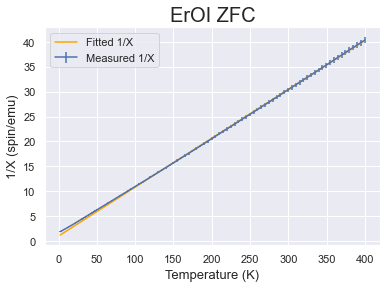

Susc error norm =  0.027897705915326938
The Weiss constant = -10.56 K
The Curie constant = 10.194
Effective moment for ErOI is 9.031 bohr ,  gj factor = 10.428


In [134]:
plt.errorbar(T,Xi,yerr = SuscErrorNormi, fmt ='-',label = 'Measured 1/X')
plt.plot(newT,resulti.best_fit,'orange', label = 'Fitted 1/X')
plt.title(comp + " " + measType, fontsize = 20)
plt.xlabel('Temperature (K)', fontsize = 13)
plt.ylabel('1/X (spin/emu)', fontsize = 13)
plt.legend()
plt.show()


print('Susc error norm = ', SuscErrorNormi[0])
print('The Weiss constant = {:.2f} K\nThe Curie constant = {:.3f}'.format(resulti.params['tc'].value,resulti.params['c'].value))

ueff, gj = calcConstants(resulti.params['c'].value,1/2)

# print(ueff/(mass/molweight)*6.02*10**-23)
print('Effective moment for {:} is {:.3f} bohr ,  gj factor = {:.3f}'.format(comp,ueff,gj))

In [135]:
print('1/X fitted parameters')
resulti.result.params.pretty_print()
print('\n Reduced chi sqr: ', resulti.result.redchi)
print('\n Chi sqr: ', resulti.result.chisqr)

1/X fitted parameters
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
c      10.19     -inf      inf  0.01008     True     None     None
tc    -10.56     -inf      inf   0.3137     True     None     None

 Reduced chi sqr:  0.0006690650382936626

 Chi sqr:  0.07894967451865219


## Log Linear

In [136]:

# plt.plot(T,Xi,'b.',alpha=.05,label = 'Measured 1/X')
# plt.plot(newT,resulti.best_fit,'orange', label = 'Fitted 1/X')
# plt.title(comp, fontsize = 20)
# plt.xlabel('Temperature (K)', fontsize = 13)
# plt.ylabel('1/X', fontsize = 13)
# plt.yscale('log')
# plt.legend()
# plt.show()

## Log Log

In [137]:
# plt.plot(T,Xi,'b.',alpha=.05,label = 'Measured 1/X')
# plt.plot(newT,resulti.best_fit,'orange', label = 'Fitted 1/X')
# plt.title(comp, fontsize = 20)
# plt.xlabel('Temperature (K)', fontsize = 13)
# plt.ylabel('1/X', fontsize = 13)
# plt.yscale('log')
# plt.xscale('log')
# plt.legend()
# plt.show()

# Print out fitted curie constant, weiss constant, chi sqr, reduced chi sqr, and magnetic moment.

In [138]:
# print('1/X fitted parameters:\n--------------------------------------------------------------------')
# resulti.params.pretty_print()
# print('\n\n--------------------------------------------------------------------')
# print(' Reduced chi sqr: ', resulti.redchi)
# print('Chi sqr: ', resulti.chisqr)
# print('--------------------------------------------------------------------\n\n')
# # print('Magnetic moment(not correct yet) = ',2.34*np.sqrt(resulti.params['c'].value))